#Recurrent neural networks

First, we add the necessary imports and set a constant seed for the random number generator in PyTorch.

In [1]:
import hashlib
import os
import requests
import re
import collections
import random
import torch
from torch import nn
from torch.nn import functional as F
import math
import matplotlib.pyplot as plt
import zipfile

torch.manual_seed(42);

Text is one of the most popular examples of sequence data. For example, an article can be simply viewed as a sequence of words, or even a sequence of characters. The common preprocessing steps for text, usually, are:

1. Load text as strings into memory.
1. Split strings into tokens (e.g., words and characters).
1. Build a table of vocabulary to map the split tokens to numerical indices.
1. Convert text into sequences of numerical indices so they can be manipulated by models easily.

To get started we load text from H. G. Wells' [*The Time Machine*](http://www.gutenberg.org/ebooks/35). This is a fairly small corpus of just over $30000$ words, but, for the purpose of what we want to illustrate, this is just fine. More realistic document collections contain many billions of words. The `read_time_machine()` function reads the dataset into a list of text lines, where each line is a string. For simplicity, here we ignore punctuation and capitalization.

In [2]:
def download(url, cache_dir=os.path.join('..', 'data')):
    """Download a file, return the local filename."""
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
        return fname
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

In [3]:
def read_time_machine():
    """Load the time machine dataset into a list of text lines."""
    with open(download('http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

lines = read_time_machine()
print(f'# text lines: {len(lines)}')
print(lines[0])
print(lines[10])

# text lines: 3221
the time machine by h g wells
twinkled and his usually pale face was flushed and animated the


The following `tokenize()` function takes a list (`lines`) as the input, where each element is a text sequence (e.g., a text line). Each text sequence is split into a list of tokens. A *token* is the basic unit in text. In the end, a list of token lists are returned, where each token is a string.

In [4]:
def tokenize(lines, token='word'):
    """Split text lines into word or character tokens."""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)

tokens = tokenize(lines)
for i in range(11):
    print(tokens[i])

['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
[]
[]
[]
[]
['i']
[]
[]
['the', 'time', 'traveller', 'for', 'so', 'it', 'will', 'be', 'convenient', 'to', 'speak', 'of', 'him']
['was', 'expounding', 'a', 'recondite', 'matter', 'to', 'us', 'his', 'grey', 'eyes', 'shone', 'and']
['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']


The string type of the token is inconvenient to be used by models, which take numerical inputs. Now let us build a dictionary, often called *vocabulary* as well, to map string tokens into numerical indices starting from $0$. To do so, we first count the unique tokens in all the documents from the training set, namely a *corpus*, and then assign a numerical index to each unique token according to its frequency. Rarely appeared tokens are often removed to reduce the complexity. Any token that does not exist in the corpus or has been removed is mapped into a special unknown token “&lt;unk&gt;”. We optionally add a list of reserved tokens, such as “&lt;pad&gt;” for padding, “&lt;bos&gt;” to represent the beginning of a sequence, and “&lt;eos&gt;” for the end of a sequence.

In [5]:
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Token frequencies
        return self._token_freqs

def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

We construct a vocabulary using the `time machine` dataset as the corpus. Then, we print the first few frequent tokens with their indices.

In [6]:
vocab = Vocab(tokens)
print(list(vocab.token_to_idx.items())[:10])

[('<unk>', 0), ('the', 1), ('i', 2), ('and', 3), ('of', 4), ('a', 5), ('to', 6), ('was', 7), ('in', 8), ('that', 9)]


Now, we can convert each text line into a list of numerical indices.

In [7]:
for i in [0, 10]:
    print('words:', tokens[i])
    print('indices:', vocab[tokens[i]])

words: ['the', 'time', 'machine', 'by', 'h', 'g', 'wells']
indices: [1, 19, 50, 40, 2183, 2184, 400]
words: ['twinkled', 'and', 'his', 'usually', 'pale', 'face', 'was', 'flushed', 'and', 'animated', 'the']
indices: [2186, 3, 25, 1044, 362, 113, 7, 1421, 3, 1045, 1]


Using the above functions, we package everything into the `load_corpus_time_machine()` function, which returns `corpus`, a list of token indices, and `vocab`, the vocabulary of the time machine corpus.
The modifications we did here are:
(i) we tokenize text into characters, not words, to simplify the later training;
(ii) `corpus` is a single list, not a list of token lists, since each text line in the `time machine` dataset is not necessarily a sentence or a paragraph.

In [11]:
def load_corpus_time_machine(max_tokens=-1):
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
len(corpus), len(vocab)
print(list(vocab.token_to_idx.items())[:50])

[('<unk>', 0), (' ', 1), ('e', 2), ('t', 3), ('a', 4), ('i', 5), ('n', 6), ('o', 7), ('s', 8), ('h', 9), ('r', 10), ('d', 11), ('l', 12), ('m', 13), ('u', 14), ('c', 15), ('f', 16), ('w', 17), ('g', 18), ('y', 19), ('p', 20), ('b', 21), ('v', 22), ('k', 23), ('x', 24), ('z', 25), ('j', 26), ('q', 27)]


We can ensure that the subsequences from two adjacent mini-batches during iteration are adjacent on the original sequence. This strategy preserves the order of split subsequences when iterating over mini-batches, hence is called *sequential partitioning*.

In [ ]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """Generate a mini-batch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y

Let us manually generate a sequence from $0$ to $34$. We assume that the batch size and number of time steps are $2$ and $5$, respectively. This means that we can generate $\lfloor (35 - 1) / 5 \rfloor= 6$ feature-label subsequence pairs. With a mini-batch size of $2$, we only get $3$ mini-batches. 

Let us print features `X` and labels `Y` for each mini-batch of subsequences read by sequential partitioning. Note that the subsequences from two adjacent mini-batches during iteration are indeed adjacent in the original sequence.

In [ ]:
my_seq = list(range(35))
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 2,  3,  4,  5,  6],
        [18, 19, 20, 21, 22]]) 
Y: tensor([[ 3,  4,  5,  6,  7],
        [19, 20, 21, 22, 23]])
X:  tensor([[ 7,  8,  9, 10, 11],
        [23, 24, 25, 26, 27]]) 
Y: tensor([[ 8,  9, 10, 11, 12],
        [24, 25, 26, 27, 28]])
X:  tensor([[12, 13, 14, 15, 16],
        [28, 29, 30, 31, 32]]) 
Y: tensor([[13, 14, 15, 16, 17],
        [29, 30, 31, 32, 33]])


Now, we wrap the above two sampling functions to a class, so that we can use it as a data iterator later.

In [ ]:
class SeqDataLoader:
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, max_tokens):
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return seq_data_iter_sequential(self.corpus, self.batch_size, self.num_steps)

Lastly, we define a function `load_data_time_machine()` that returns both the data iterator and the vocabulary, so we can use it similarly as other functions with the `load_data` prefix, such as `load_data_fashion_mnist()` defined in *Laboratory 3*.

In [ ]:
def load_data_time_machine(batch_size, num_steps, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(
        batch_size, num_steps, max_tokens)
    return data_iter, data_iter.vocab

In order to implement a language model with RNNs, we use functions provided by the high-level APIs of PyTorch. We begin by reading the `time machine` dataset.

In [ ]:
batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

High-level APIs provide implementations of recurrent neural networks. We construct the recurrent neural network layer `rnn_layer` with a single hidden layer and $256$ hidden units.

In [ ]:
num_hiddens = 256
rnn_layer = nn.RNN(len(vocab), num_hiddens)

We use a tensor to initialize the hidden state, whose shape is
(number of hidden layers, batch size, number of hidden units).

In [ ]:
state = torch.zeros((1, batch_size, num_hiddens))
state.shape

torch.Size([1, 32, 256])

With a hidden state and an input, we can compute the output with the updated hidden state. It should be emphasized that the "output" (`Y`) of `rnn_layer` does *not* involve computation of output layers: it refers to the hidden state at *each* time step, and they can be used as the input to the subsequent output layer.

In [ ]:
X = torch.rand(size=(num_steps, batch_size, len(vocab)))
Y, state_new = rnn_layer(X, state)
Y.shape, state_new.shape

(torch.Size([35, 32, 256]), torch.Size([1, 32, 256]))

Recall that each token is represented as a numerical index in `train_iter`. Feeding these indices directly to a neural network might make it hard to learn. We often represent each token as a more expressive feature vector. The easiest representation is called *one-hot encoding*.

In a nutshell, we map each index to a different unit vector: assume that the number of different tokens in the vocabulary is $N$ (`len(vocab)`) and the token indices range from $0$ to $N-1$. If the index of a token is the integer $i$, then we create a vector of all $0$s with a length of $N$ and set the element at position $i$ to $1$. This vector is the one-hot vector of the original token. The one-hot vectors with indices $0$ and $2$ are shown below.

In [ ]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

The shape of the mini-batch that we sample each time is (batch size, number of time steps). The `F.one_hot()` function transforms such a mini-batch into a three-dimensional tensor, where the last dimension equals to the vocabulary size (`len(vocab)`). We often transpose the input, so that we will obtain an output of shape (number of time steps, batch size, vocabulary size). This will allow us to more conveniently loop through the outermost dimension for updating hidden states of a mini-batch, time step by time step.

In [ ]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

We define an `RNNModel` class for a complete RNN model. Note that `rnn_layer` only contains the hidden recurrent layers, so we need to create a separate output layer.

In [ ]:
class RNNModel(nn.Module):
    """The RNN model."""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        self.linear = nn.Linear(self.num_hiddens, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # The fully connected layer will first change the shape of `Y` to
        # (`num_steps` * `batch_size`, `num_hiddens`). Its output shape is
        # (`num_steps` * `batch_size`, `vocab_size`).
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU` takes a tensor as hidden state
            return  torch.zeros((self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                 device=device)
        else:
            # `nn.LSTM` takes a tuple of hidden states
            return (torch.zeros((
                self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))

Let us first define the prediction function to generate new characters following
the user-provided `prefix`, which is a string containing several characters.  When looping through these beginning characters in `prefix`, we keep passing the hidden state to the next time step without generating any output. This is called the *warm-up* period, during which the model updates itself (e.g., update the hidden state), but does not make predictions. After the warm-up period, the hidden state is generally better than its initialized value at the beginning. So we generate the predicted characters and emit them.

In [ ]:
def predict(prefix, num_preds, net, vocab, device):
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

Now we can test the `predict()` function. We specify the prefix as `time traveller` and have it generate $10$ additional characters. Given that we have not trained the network yet, i.e., the model has random weights, it will generate nonsensical predictions.

In [ ]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In [ ]:
device = try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)
predict('time traveller', 10, net, vocab, device)

'time travellervv<unk>vvvvvvv'

Below we define a function to *clip the gradients* of a model that is constructed by the high-level APIs. Also, note that we compute the gradient norm over all the model parameters.

In [ ]:
def grad_clipping(net, theta):
    """Clip the gradient."""
    params = [p for p in net.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

Before training the model, let us define a function to train the model in one epoch. It differs from how we train the model of *Laboratory 3* in three places:

1. Different types of recurrent layers will result in differences in the initialization of hidden states.
1. We clip the gradients before updating the model parameters. This ensures that the model does not diverge, even when gradients blow up at some point during the training process.
1. We use perplexity to evaluate the model. As discussed in the course, this ensures that sequences of different lengths are comparable.

Specifically, when sequential partitioning is used, we initialize the hidden state only at the beginning of each epoch. Since the $i$th subsequence example in the next mini-batch is adjacent to the current $i$th subsequence example, the hidden state at the end of the current mini-batch will be used to initialize the hidden state at the beginning of the next mini-batch. In this way, historical information of the sequence stored in the hidden state might flow over adjacent subsequences within an epoch. However, the computation of the hidden state at any point depends on all the previous mini-batches in the same epoch, which complicates the gradient computation. To reduce computational cost, we detach the gradient before processing any mini-batch, so that the gradient computation of the hidden state is always limited to the time steps in one mini-batch. 

Same as the `train_epoch()` function in *Laboratory 3*, `optimizer` is a built-in optimization function in PyTorch.

In [ ]:
def train_epoch(net, train_iter, loss, optimizer, device):
    """Train a net within one epoch."""
    state = None
    # Sum of training loss, no. of tokens
    total_loss = 0
    total_tokens = 0
    for X, Y in train_iter:
        if state is None:
            # Initialize `state` when it is the first iteration
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM`
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        optimizer.zero_grad()
        l.backward()
        grad_clipping(net, 1)
        optimizer.step()
        total_loss += float(l * y.numel())
        total_tokens += y.numel()
    return math.exp(total_loss / total_tokens)

The training function supports an RNN model implemented using high-level APIs.

In [ ]:
def train(net, train_iter, vocab, lr, num_epochs, device):
    """Train a model."""
    loss = nn.CrossEntropyLoss()
    perplexities = []
    # Initialize
    optimizer = torch.optim.SGD(net.parameters(), lr)
    # Train and predict
    for epoch in range(num_epochs):
        ppl = train_epoch(
            net, train_iter, loss, optimizer, device)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller', 50, net, vocab, device))
            perplexities.append(ppl)
    print(f'perplexity {ppl:.1f}, device {str(device)}')
    print(predict('time traveller', 50, net, vocab, device))
    print(predict('traveller', 50, net, vocab, device))

    return perplexities

Now we can train the RNN model by calling the `train()` function. Since we only use $10000$ tokens in the dataset, the model needs more epochs to converge better.

In [ ]:
num_epochs, lr = 500, 1
perplexities = train(net, train_iter, vocab, lr, num_epochs, device) #1 min

time traveller the the the the the the the the the the the the t
time traveller and the the the the the the the the the the the t
time traveller the the the the the the the the the the the the t
time traveller the this the thice some that sime time sion so di
time travellere med an ans ano he mant of the thave and have the
time travellerthithe monght rousthe tree the the thatour and the
time travellerickthe thith sion so deand in the reatlist ou the 
time traveller surded this timension of his there that in a dint
time traveller curee and the enot of camd an aile hathist is tha
time traveller pat en sthere wrea touredinst in time tore ard th
time travelleris tha fexthestithe wspectofte sime tiok an thes a
time travellerit to ge there wral thenting thanethe thile creerp
time traveller suthed this soree blate move cong there was avire
time traveller the cince arealdiche time traveller the limather 
time travellerit to ag her aby cand the tome trovelle back the f
time travelleris the prav

Finally, we plot the perplexities obtained during training, using the `plot_perplexity()` function.

In [ ]:
def plot_perplexity(perplexities):
    epochs = range(10, len(perplexities * 10) + 1, 10)
    plt.plot(epochs, perplexities, 'b', label='Train perplexity') 
    plt.title('Training perplexity') 
    plt.xlabel('Epochs') 
    plt.ylabel('Perplexity') 
    plt.legend()  
    plt.show()

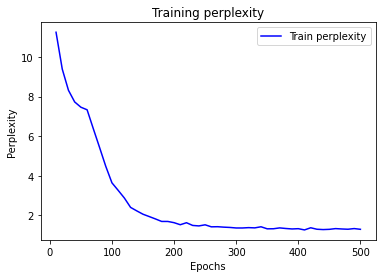

In [ ]:
plot_perplexity(perplexities)

In [4]:
#Ex1

import torch
from torch import nn

torch.manual_seed(42);

rnn = nn.RNN(2, 4)
input = torch.randn(5, 1, 2)
h0 = torch.randn(1, 1, 4)
output, hn = rnn(input, h0)

print(output)

tensor([[[ 0.6871, -0.3593,  0.4704, -0.6224]],

        [[-0.3548, -0.5317,  0.3520, -0.8332]],

        [[ 0.5139, -0.5306, -0.1322, -0.7962]],

        [[ 0.1453, -0.1416,  0.4736, -0.6271]],

        [[ 0.0465, -0.4846,  0.1393, -0.8029]]], grad_fn=<StackBackward0>)


In [16]:
#Ex2

import hashlib
import os
import requests
import re
import collections
import random
import torch
from torch import nn
from torch.nn import functional as F
import math
import matplotlib.pyplot as plt
import zipfile

torch.manual_seed(42);

def download(url, cache_dir=os.path.join('..', 'data')):
    """Download a file, return the local filename."""
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
        return fname
    print(f'Downloading {fname} from {url}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def read_time_machine():
    """Load the time machine dataset into a list of text lines."""
    with open(download('http://d2l-data.s3-accelerate.amazonaws.com/timemachine.txt'), 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

def tokenize(lines, token='word'):
    """Split text lines into word or character tokens."""
    if token == 'word':
        return [line.split() for line in lines]
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)
        
class Vocab:
    """Vocabulary for text."""
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        # Sort according to frequencies
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        # The index for the unknown token is 0
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # Index for the unknown token
        return 0

    @property
    def token_freqs(self):  # Token frequencies
        return self._token_freqs

def count_corpus(tokens):
    """Count token frequencies."""
    # Here `tokens` is a 1D list or 2D list
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # Flatten a list of token lists into a list of tokens
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

def load_corpus_time_machine(max_tokens=-1):
    """Return token indices and the vocabulary of the time machine dataset."""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # Since each text line in the time machine dataset is not necessarily a
    # sentence or a paragraph, flatten all the text lines into a single list
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """Generate a mini-batch of subsequences using sequential partitioning."""
    # Start with a random offset to partition a sequence
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y
        
class SeqDataLoader:
    """An iterator to load sequence data."""
    def __init__(self, batch_size, num_steps, max_tokens):
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return seq_data_iter_sequential(self.corpus, self.batch_size, self.num_steps)
    
def load_data_time_machine(batch_size, num_steps, max_tokens=10000):
    """Return the iterator and the vocabulary of the time machine dataset."""
    data_iter = SeqDataLoader(
        batch_size, num_steps, max_tokens)
    return data_iter, data_iter.vocab

class RNNModel(nn.Module):
    """The RNN model."""
    def __init__(self, rnn_layer, vocab_size, **kwargs):
        super(RNNModel, self).__init__(**kwargs)
        self.rnn = rnn_layer
        self.vocab_size = vocab_size
        self.num_hiddens = self.rnn.hidden_size
        self.linear = nn.Linear(self.num_hiddens, self.vocab_size)

    def forward(self, inputs, state):
        X = F.one_hot(inputs.T.long(), self.vocab_size)
        X = X.to(torch.float32)
        Y, state = self.rnn(X, state)
        # The fully connected layer will first change the shape of `Y` to
        # (`num_steps` * `batch_size`, `num_hiddens`). Its output shape is
        # (`num_steps` * `batch_size`, `vocab_size`).
        output = self.linear(Y.reshape((-1, Y.shape[-1])))
        return output, state

    def begin_state(self, device, batch_size=1):
        if not isinstance(self.rnn, nn.LSTM):
            # `nn.GRU` takes a tensor as hidden state
            return  torch.zeros((self.rnn.num_layers,
                                 batch_size, self.num_hiddens),
                                 device=device)
        else:
            # `nn.LSTM` takes a tuple of hidden states
            return (torch.zeros((
                self.rnn.num_layers,
                batch_size, self.num_hiddens), device=device),
                    torch.zeros((
                        self.rnn.num_layers,
                        batch_size, self.num_hiddens), device=device))
        
def train_epoch(net, train_iter, loss, optimizer, device):
    """Train a net within one epoch."""
    state = None
    # Sum of training loss, no. of tokens
    total_loss = 0
    total_tokens = 0
    for X, Y in train_iter:
        if state is None:
            # Initialize `state` when it is the first iteration
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if not isinstance(state, tuple):
                # `state` is a tensor for `nn.GRU`
                state.detach_()
            else:
                # `state` is a tuple of tensors for `nn.LSTM`
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        optimizer.zero_grad()
        l.backward()
        grad_clipping(net, 1)
        optimizer.step()
        total_loss += float(l * y.numel())
        total_tokens += y.numel()
    return math.exp(total_loss / total_tokens)

def train(net, train_iter, vocab, lr, num_epochs, device):
    """Train a model."""
    loss = nn.CrossEntropyLoss()
    perplexities = []
    # Initialize
    optimizer = torch.optim.SGD(net.parameters(), lr)
    # Train and predict
    for epoch in range(num_epochs):
        ppl = train_epoch(
            net, train_iter, loss, optimizer, device)
        if (epoch + 1) % 10 == 0:
            print(predict('traveller', 20, net, vocab, device))
            perplexities.append(ppl)
    print(f'perplexity {ppl:.1f}, device {str(device)}')
    #print(predict('time traveller', 50, net, vocab, device))
    print(predict('traveller', 20, net, vocab, device))

    return perplexities

def grad_clipping(net, theta):
    """Clip the gradient."""
    params = [p for p in net.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

def predict(prefix, num_preds, net, vocab, device):
    """Generate new characters following the `prefix`."""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:  # Warm-up period
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):  # Predict `num_preds` steps
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])
            
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f'cuda:{i}')
    return torch.device('cpu')

batch_size, num_steps = 30, 10
train_iter, vocab = load_data_time_machine(batch_size, num_steps)

num_hiddens = 32
rnn_layer = nn.RNN(len(vocab), num_hiddens, 2)

device = try_gpu()
net = RNNModel(rnn_layer, vocab_size=len(vocab))
net = net.to(device)

num_epochs, lr = 200, 1.5
perplexities = train(net, train_iter, vocab, lr, num_epochs, device) #1 min
#print(predict('traveller', 20, net, vocab, device))

traveller the this the this t
traveller a sto and so said t
traveller a say so of sald th
traveller murif so whit so di
traveller a fore all al soles
traveller the said the said t
traveller the prover a movess
traveller the said the time t
traveller the time traveller 
traveller the medical so we s
traveller the time traveller 
travellery which a line a lat
traveller the meriment of spa
traveller a line a line a lin
traveller the time traveller 
traveller the procerine trave
traveller so man and why he s
traveller so expere so explon
traveller the time traveller 
traveller the time traveller 
perplexity 5.1, device cuda:0
traveller the time traveller 
